In [25]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

import numpy as np
from torch import nn, optim
from tqdm import tqdm

class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        class_names = os.listdir(data_dir)
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
        
        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.images.append(image_path)
                self.labels.append(self.class_to_idx[class_name])
        
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        with open(image_path, 'rb') as f:
            image = Image.open(f).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = "/Users/nishkamehlawat/Desktop/Training"
test_dir = "/Users/nishkamehlawat/Desktop/Testing"

train_dataset = BrainTumorDataset(train_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = BrainTumorDataset(test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.input_size = input_size  # Define input_size as an attribute
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Reshape input tensor to [batch_size, seq_len, input_size]
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.input_size)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :]) 
        
        return out
    
    
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 224 * 224 * 3  # Adjusted input size
hidden_size = 128
num_layers = 2
num_classes = len(train_dataset.class_to_idx)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_dataset)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Accuracy: {accuracy}%")

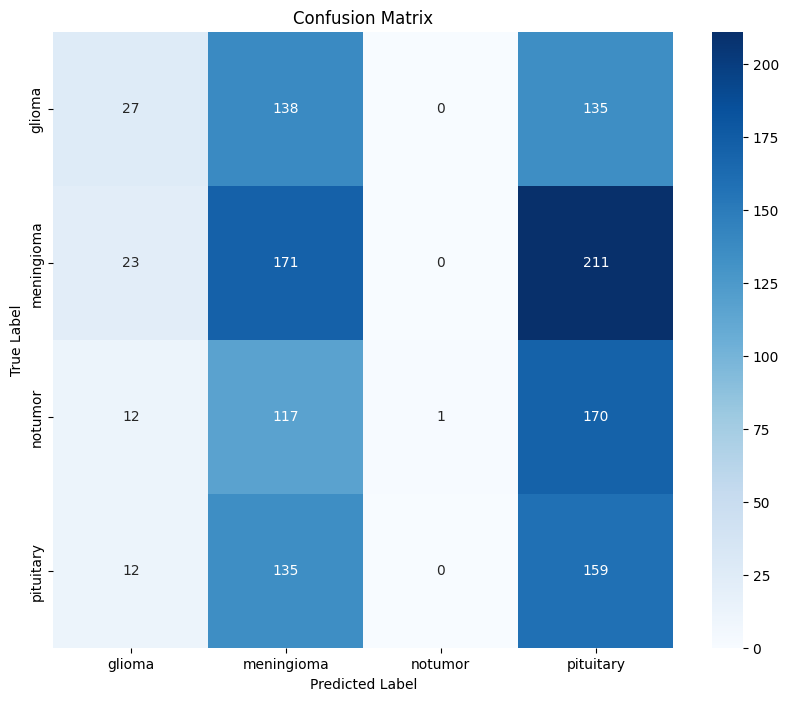

Precision: 0.4763083136612548
Recall: 0.25879084967320265
F1-score: 0.2073064583744666


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Evaluate the model on the test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
class_names = ["glioma","meningioma","notumor","pituitary"]
sns.heatmap(cm, cmap='Blues', annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
#plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.4096109839816934
